In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:

from collections import defaultdict
from dataclasses import replace
import itertools
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, cdist
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings, load_or_compute_embeddings

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import KFold, cross_val_score

In [5]:
model_dir = "outputs/models/w2v2_6_8/phoneme"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
# model_checkpoint = "../out/ce_model_phoneme_6_32/checkpoint-800/"
equiv_dataset_path = "data/timit_equivalence_facebook-wav2vec2-base_6-phoneme-1.pkl"

state_space_spec_path = "out/state_space_specs/all_words.pkl"
output_dir = "."

# Add 4 frames prior to phoneme onset to each trajectory
expand_frame_window = (4, 0)

metric = "cosine"

In [6]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [7]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [8]:
with open(state_space_spec_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

<Axes: xlabel='idx_in_level', ylabel='Count'>

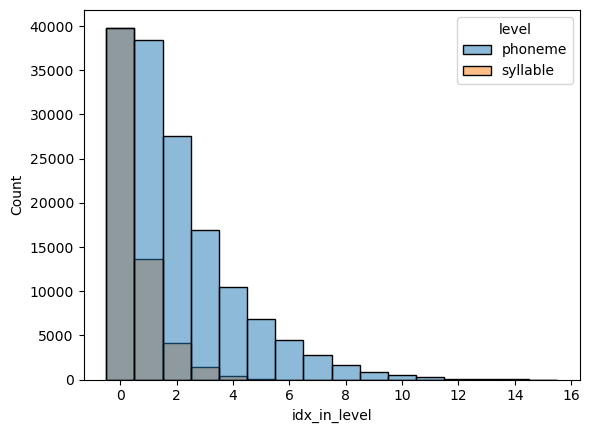

In [9]:
state_space_spec.cuts["idx_in_level"] = state_space_spec.cuts.groupby(["label", "instance_idx", "level"]).cumcount()
state_space_spec.cuts["num_frames"] = state_space_spec.cuts.offset_frame_idx - state_space_spec.cuts.onset_frame_idx
sns.histplot(data=state_space_spec.cuts.reset_index(), x="idx_in_level", hue="level", discrete=True)

In [10]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

In [18]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, expand_window=expand_frame_window, pad=np.nan)

In [19]:
lengths = [np.isnan(traj_i[:, :, 0]).argmax(axis=1) for traj_i in trajectory]

In [20]:
def evaluate_temporal_generalization(trajectory, lengths, train_frame, test_frame):
    X, Y = [], []
    for traj_i, lengths_i in zip(trajectory, lengths):
        analyze = ((lengths_i > test_frame) & (lengths_i > train_frame)).nonzero()[0]
        for idx in analyze:
            X.append(traj_i[idx, train_frame])
            Y.append(traj_i[idx, test_frame])

    if len(X) < 100:
        return np.nan

    X = np.stack(X)
    Y = np.stack(Y)

    # Fit linear model
    model = RidgeCV(cv=KFold(3, shuffle=True))
    return cross_val_score(model, X, Y, cv=KFold(3, shuffle=True), scoring="r2")

In [ ]:
temporal_generalization_scores = np.zeros((trajectory[0].shape[1], trajectory[0].shape[1])) * np.nan
for train_frame, test_frame in tqdm(list(itertools.product(range(trajectory[0].shape[1]), repeat=2))):
    scores = evaluate_temporal_generalization(trajectory, lengths, train_frame, test_frame)
    temporal_generalization_scores[train_frame, test_frame] = np.mean(scores)

  0%|          | 0/7396 [00:00<?, ?it/s]

In [ ]:
temporal_generalization_df = pd.DataFrame(temporal_generalization_scores, columns=pd.Index(range(trajectory[0].shape[1]), name="test_frame"),
                                          index=pd.Index(range(trajectory[0].shape[1]), name="train_frame"))
temporal_generalization_df.head()

In [ ]:
temporal_generalization_df.to_csv(Path(output_dir) / "temporal_generalization.csv")

In [ ]:
plot_df = temporal_generalization_df.iloc[:30, :30]

ax = sns.heatmap(plot_df, cmap="RdBu_r", center=0, xticklabels=10, yticklabels=10)

assert expand_frame_window[1] == 0
# Draw word onset
if expand_frame_window[0] != 0:
    ax.axvline(expand_frame_window[0], color="gray", linestyle="--")
    ax.axhline(expand_frame_window[0], color="gray", linestyle="--")

ax.set_xlabel("Test frame")
ax.set_ylabel("Train frame")

## Temporal generalization by cut

In [53]:
def evaluate_temporal_generalization_by_cuts(
        model_representations, mymap,
        train_cut_position, train_frame_offset,
        test_cut_position, test_frame_offset,
        min_samples=100
):
    frames = mymap[train_cut_position, train_frame_offset, test_cut_position, test_frame_offset]
    if len(frames) < min_samples:
        return np.nan

    X, Y = [], []
    for train_frame, test_frame in frames:
        X.append(model_representations[train_frame])
        Y.append(model_representations[test_frame])

    X = np.stack(X)
    Y = np.stack(Y)

    # Fit linear model
    model = RidgeCV(cv=KFold(3, shuffle=True))
    return cross_val_score(model, X, Y, cv=KFold(3, shuffle=True), scoring="r2")

In [54]:
def analyze_temporal_generalization_by_cut(cut_level, min_samples=100):
    tg_cut_df = state_space_spec.cuts.xs(cut_level, level="level").copy().sort_index()

    # Find max number of frames for each unit position such that we have a minimum
    # number of samples at each frame in that position
    num_frames_for_position = {}
    for frame in range(tg_cut_df.num_frames.max()):
        num_samples = tg_cut_df.groupby("idx_in_level").apply(lambda xs: (xs.num_frames > frame).sum())
        for position, num_samples in num_samples.items():
            if num_samples > min_samples:
                num_frames_for_position[position] = frame
    
    # maps (train_position, train_frame_offset, test_position, test_frame_offset) -> [(train_frame, test_frame)]
    mymap = defaultdict(list)

    # skip positions which don't have enough samples
    pair_tg_df = tg_cut_df[tg_cut_df.idx_in_level.isin(num_frames_for_position.keys())]
    for (label, instance_idx), cuts_i in tqdm(pair_tg_df.groupby(["label", "instance_idx"])):
        cuts_i = cuts_i.set_index("idx_in_level")
        for pos1, pos2 in itertools.product(cuts_i.index, repeat=2):
            cuts_i1, cuts_i2 = cuts_i.loc[pos1], cuts_i.loc[pos2]
            num_frames_1 = min(num_frames_for_position[pos1], cuts_i1.num_frames.max())
            num_frames_2 = min(num_frames_for_position[pos2], cuts_i2.num_frames.max())
            for frame_offset1, frame_offset2 in itertools.product(range(num_frames_1), range(num_frames_2)):
                mymap[pos1, frame_offset1, pos2, frame_offset2].append((
                    cuts_i1.onset_frame_idx + frame_offset1,
                    cuts_i2.onset_frame_idx + frame_offset2
                ))

    all_eval_frames = [(position, frame) for position in num_frames_for_position
                   for frame in range(num_frames_for_position[position])]

    tg_scores_cut = np.zeros((len(all_eval_frames), len(all_eval_frames))) * np.nan
    for ((i, (train_cut_position, train_frame)), (j, (test_cut_position, test_frame))) in tqdm(list(itertools.product(enumerate(all_eval_frames), repeat=2))):
        scores = evaluate_temporal_generalization_by_cuts(
            model_representations, mymap,
            train_cut_position, train_frame,
            test_cut_position, test_frame,
            min_samples=min_samples
        )
        tg_scores_cut[i, j] = np.mean(scores)

    tg_scores_cut_df = pd.DataFrame(tg_scores_cut, columns=pd.MultiIndex.from_tuples(all_eval_frames, names=["position", "frame"]),
                                    index=pd.MultiIndex.from_tuples(all_eval_frames, names=["position", "frame"]))
    
    return tg_scores_cut_df, num_frames_for_position

In [55]:
def plot_tg_scores(tg_scores_df, num_frames_for_position, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Flatten index to string values
    tg_scores_df = tg_scores_df.copy()
    tg_scores_df.index = tg_scores_df.index.map(lambda x: f"{x[0]}:{x[1]}")
    tg_scores_df.columns = tg_scores_df.columns.map(lambda x: f"{x[0]}:{x[1]}")

    ax = sns.heatmap(tg_scores_df, cmap="RdBu_r", center=0)

    # plot xticks just at cut unit borders
    ax.set_xticks(np.cumsum([num_frames_for_position[position] for position in num_frames_for_position]))
    ax.set_yticks(np.cumsum([num_frames_for_position[position] for position in num_frames_for_position]))
    ax.set_xticklabels([f"{position}" for position in num_frames_for_position])
    ax.set_yticklabels([f"{position}" for position in num_frames_for_position])

    # Draw cut borders
    acc = 0
    for position, num_frames in num_frames_for_position.items():
        acc += num_frames
        ax.axvline(acc, color="gray", linestyle="--", alpha=0.5)
        ax.axhline(acc, color="gray", linestyle="--", alpha=0.5)

    ax.set_title(title)
    ax.set_xlabel("Test frame")
    ax.set_ylabel("Train frame")

    return ax

  0%|          | 0/2 [00:00<?, ?it/s]

phoneme


  0%|          | 0/39825 [00:00<?, ?it/s]

  0%|          | 0/9409 [00:00<?, ?it/s]

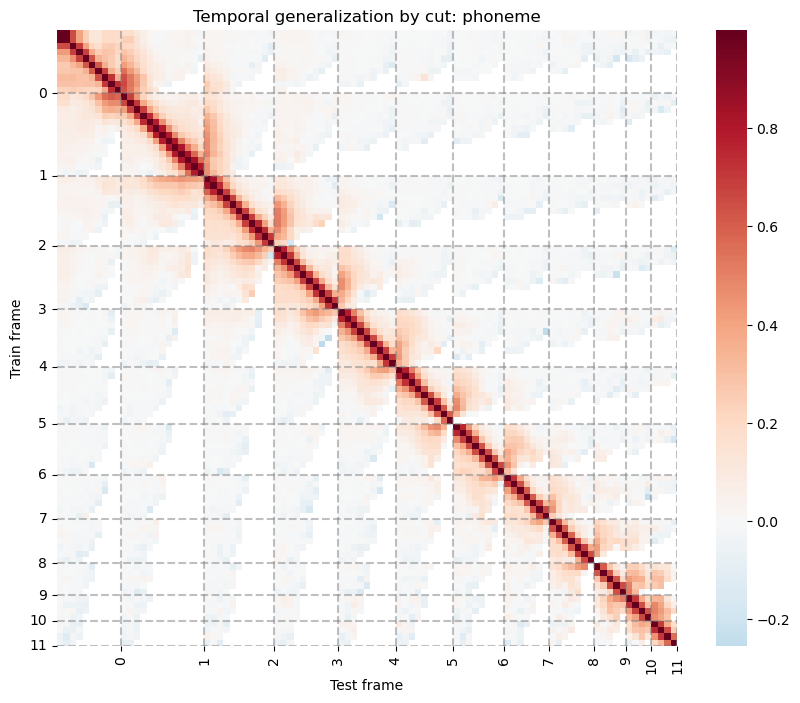

syllable


  0%|          | 0/39825 [00:00<?, ?it/s]

  0%|          | 0/10404 [00:00<?, ?it/s]

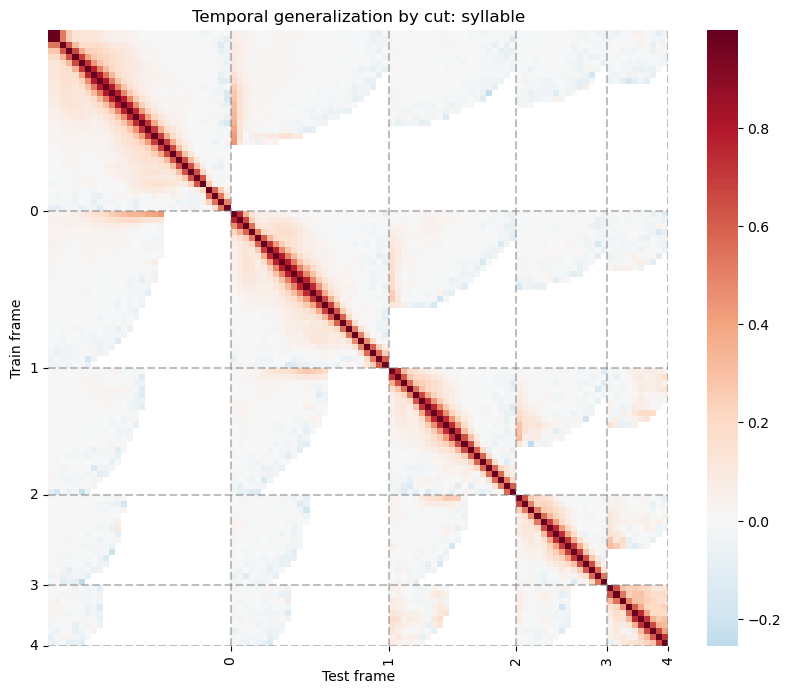

In [57]:
for level in tqdm(state_space_spec.cuts.index.get_level_values("level").unique()):
    print(level)

    tg_scores_cut_df, num_frames_for_position = analyze_temporal_generalization_by_cut(level)
    tg_scores_cut_df.to_csv(Path(output_dir) / f"temporal_generalization-cut_{level}.csv")

    ax = plot_tg_scores(tg_scores_cut_df, num_frames_for_position, f"Temporal generalization by cut: {level}")
    plt.show()